<a href="https://colab.research.google.com/github/sis00211/4dong4dong/blob/main/Clustering_and_Regression_Daily_Electrical_Load_Profiles_and_Prediction_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Machine Learning for the Built Environment - Unsupervised Learning using Clustering and Supervised Prediction using Regression

- Created by Clayton Miller - clayton@nus.edu.sg - miller.clayton@gmail.com

This notebook is an introduction to the machine learning concepts of clustering and preduction using regression. We will use the Building Data Genome Project data set to analyze electrical meter data from non-residential buildings.

## The Scikit Learn Machine Learning Library

In this series of videos, we will learn a new library called Scikit-Learn that includes various Machine Learning Models:

### https://scikit-learn.org/stable/

![alt text](https://raw.githubusercontent.com/buds-lab/the-building-data-genome-project/master/docs/edx-graphics/EDX-ML-ScikitLearn-2.png)



## Scikit-Learn Cheat Sheet

A handy flow chart is available open source from the scikit-learn community from: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

![alt text](https://raw.githubusercontent.com/buds-lab/the-building-data-genome-project/master/docs/edx-graphics/EDX-ML-ScikitLearn-1.png)


## Using the Building Data Genome Project Data Set for Clustering and Regression Prediction

Let's use the lectrical meter data to create clusters of typical load profiles for analysis. First we can load our conventional packages

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib


Next let's load all the packages we will need for the clustering and regression analysis

In [ ]:
import sklearn
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor

from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
import numpy as np
from datetime import datetime


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir("/content/gdrive/My Drive/EDX Data Science for Construction, Architecture and Engineering/3 - Construction - Pandas Fundamentals/meter_data/")

# Using Unsupervised Learning to Cluster Daily Load Profiles

The first thing we will use the library for is to analyze the daily load profiles from an electrical meter

Let's load an example meter data file and do a clustering analysis of the data. We will be following the tutorial found on the [Data-Driven Building](https://cargocollective.com/buildingdata/DayFilter-Unsupervised-Pattern-Filtering) blog.



## Load meter data from a single building

In [ ]:
ls

In [ ]:
df = pd.read_csv('Office_Amelie.csv', index_col = "timestamp", parse_dates=True)

In [ ]:
df

,Office_Amelie,Time,Date
timestamp,,,
2015-01-01 00:00:00,11.81,00:00:00,2015-01-01
2015-01-01 01:00:00,11.29,01:00:00,2015-01-01
2015-01-01 02:00:00,12.02,02:00:00,2015-01-01
2015-01-01 03:00:00,11.45,03:00:00,2015-01-01
2015-01-01 04:00:00,11.85,04:00:00,2015-01-01
...,...,...,...
2015-12-31 19:00:00,16.50,19:00:00,2015-12-31
2015-12-31 20:00:00,14.03,20:00:00,2015-12-31
2015-12-31 21:00:00,3.07,21:00:00,2015-12-31


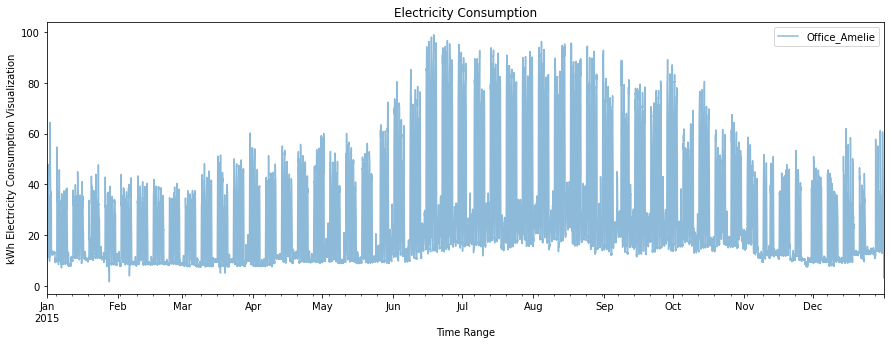

In [ ]:
df.plot(alpha=0.5, figsize=(15, 5))
plt.title("Electricity Consumption")
plt.xlabel("Time Range")
plt.ylabel("kWh Electricity Consumption Visualization");

Let's zoom in on smaller time range to see more detailed patterns

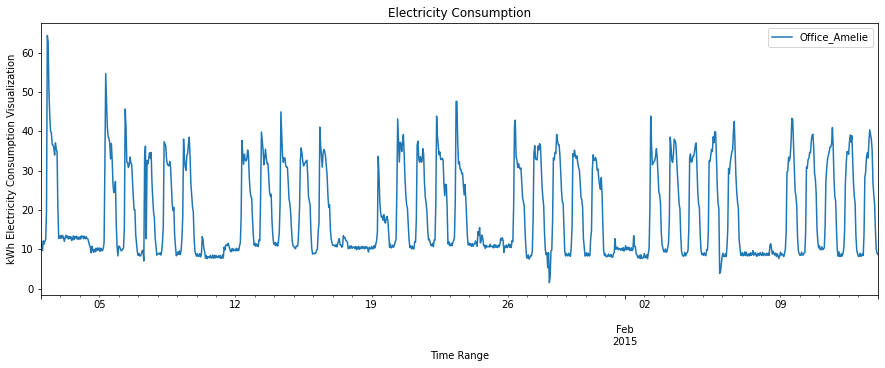

In [ ]:
df.truncate(before='01-02-2015', after='14-02-2015').plot(figsize=(15,5))
plt.title("Electricity Consumption")
plt.xlabel("Time Range")
plt.ylabel("kWh Electricity Consumption Visualization");

## Conventional Daily Profile Analysis - Weekday vs. Weekend

It appears that there is some standard weekday vs. weekend behaviour and a few basic types of daily patterns.

Let's first do it the conventional way by looking at all the daily profiles. We'll pivot to get a DataFrame that can be plotted the way we needed.

In [ ]:
df['Date'] = df.index.map(lambda t: t.date())
df['Time'] = df.index.map(lambda t: t.time())

In [ ]:
df.head()

,Office_Amelie,Date,Time
timestamp,,,
2015-01-01 00:00:00,11.81,2015-01-01,00:00:00
2015-01-01 01:00:00,11.29,2015-01-01,01:00:00
2015-01-01 02:00:00,12.02,2015-01-01,02:00:00
2015-01-01 03:00:00,11.45,2015-01-01,03:00:00
2015-01-01 04:00:00,11.85,2015-01-01,04:00:00


In [ ]:
df_pivot = pd.pivot_table(df, values='Office_Amelie', index='Date', columns='Time')


In [ ]:
df_pivot.head()


Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.81,11.29,12.02,11.45,11.85,11.02,12.11,11.39,47.91,47.53,...,31.88,31.03,31.90,33.55,33.60,35.24,35.52,19.07,11.71,11.06
2015-01-02,11.87,11.19,9.71,12.18,11.38,12.12,12.47,19.86,64.34,62.68,...,36.68,36.51,35.82,33.99,37.08,35.50,34.77,20.80,12.78,13.39
2015-01-03,12.86,13.59,12.86,13.53,12.90,12.06,13.02,13.64,12.96,13.38,...,12.29,12.53,13.46,12.49,13.26,12.92,13.40,12.61,13.12,12.54
2015-01-04,13.17,12.64,13.47,13.01,13.37,12.73,13.37,12.72,13.20,12.78,...,9.14,10.82,9.92,9.29,10.01,9.41,10.31,9.63,10.37,9.85
2015-01-05,10.38,9.51,10.30,9.67,9.70,10.27,11.73,31.82,54.69,47.74,...,33.00,36.94,32.56,26.46,24.44,25.47,27.26,16.56,10.75,8.38


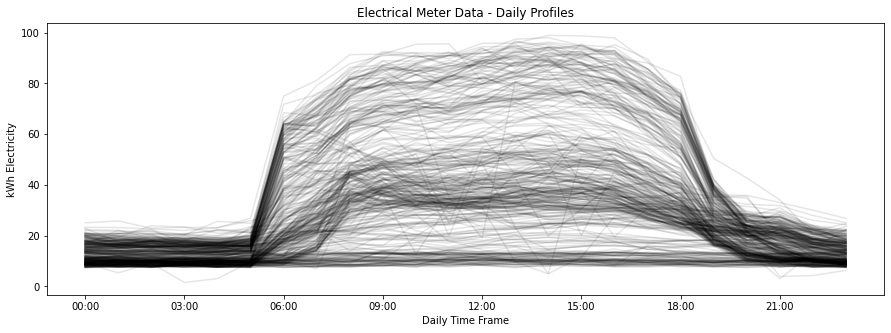

In [ ]:
df_pivot.T.plot(legend=False, figsize=(15,5), color='k', alpha=0.1, xticks=np.arange(0, 86400, 10800))
plt.title("Electrical Meter Data - Daily Profiles")
plt.xlabel("Daily Time Frame")
plt.ylabel("kWh Electricity");

Looks like we have quite a few pretty common patterns and a few outlier patterns where we have some consumption in the early morning and late night hours.

How can we divide this dataset up according to conventional wisdom -- the first obvious choice is to divide between weekdays vs. the weekends.

Let's look at weekdays first:

In [ ]:
df['Weekday'] = df.index.map(lambda t: t.date().weekday())

In [ ]:
df.head()


,Office_Amelie,Date,Time,Weekday
timestamp,,,,
2015-01-01 00:00:00,11.81,2015-01-01,00:00:00,3
2015-01-01 01:00:00,11.29,2015-01-01,01:00:00,3
2015-01-01 02:00:00,12.02,2015-01-01,02:00:00,3
2015-01-01 03:00:00,11.45,2015-01-01,03:00:00,3
2015-01-01 04:00:00,11.85,2015-01-01,04:00:00,3


In [ ]:
df_pivot_weekday = pd.pivot_table(df[(df.Weekday < 5)], values='Office_Amelie', index='Date', columns='Time')

In [ ]:
df_pivot_weekday.head()

Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.81,11.29,12.02,11.45,11.85,11.02,12.11,11.39,47.910,47.5300,...,31.88,31.03,31.90,33.55,33.60,35.24,35.52,19.07,11.71,11.06
2015-01-02,11.87,11.19,9.71,12.18,11.38,12.12,12.47,19.86,64.340,62.6800,...,36.68,36.51,35.82,33.99,37.08,35.50,34.77,20.80,12.78,13.39
2015-01-05,10.38,9.51,10.30,9.67,9.70,10.27,11.73,31.82,54.690,47.7400,...,33.00,36.94,32.56,26.46,24.44,25.47,27.26,16.56,10.75,8.38
2015-01-06,10.85,10.71,10.26,9.66,9.75,10.13,10.37,15.65,45.680,41.3200,...,33.50,31.99,31.66,27.48,23.37,20.08,20.08,13.72,11.49,9.39
2015-01-07,8.50,8.96,8.36,8.36,8.95,9.76,9.75,7.06,33.785,36.2475,...,34.54,33.25,34.63,27.26,23.02,19.52,18.00,12.85,10.86,8.55


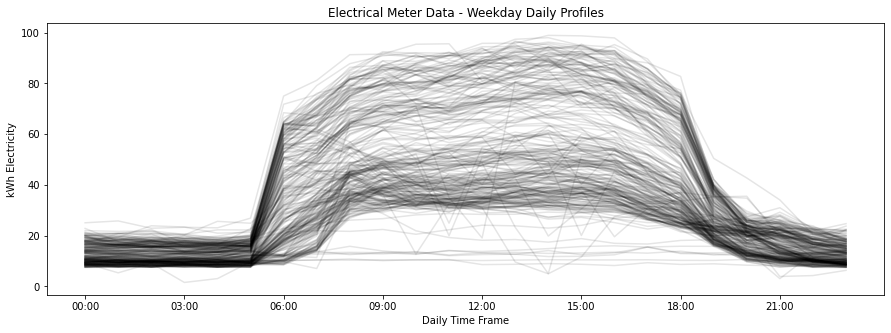

In [ ]:
df_pivot_weekday.T.plot(legend=False, figsize=(15,5), color='k', alpha=0.1, xticks=np.arange(0, 86400, 10800))
plt.title("Electrical Meter Data - Weekday Daily Profiles")
plt.xlabel("Daily Time Frame")
plt.ylabel("kWh Electricity");

It can be noticed that there is still quite a bit of anomolous-looking daily profiles that are not characterized only by the day of the week -- this can be due to holidays, weird schedules, or actually deviant behaviour.



## Manual indentification of clusters

There also seems to be varying levels of consumption throughout the course of a year. This is likely because of weather effects or schedule changes.

These could be considered "clusters" of behavior due to the course of

Let's try weekend:

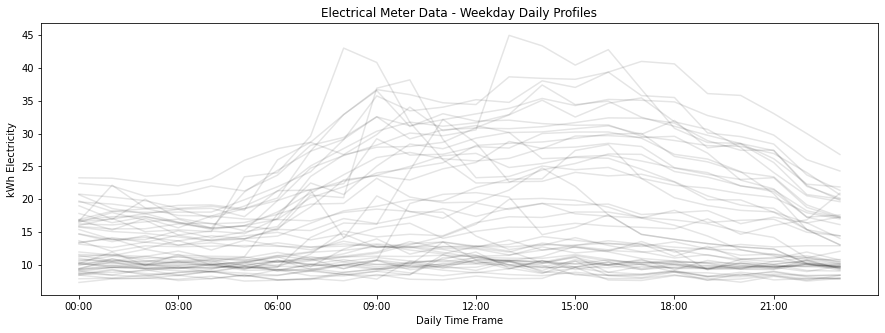

In [ ]:
df_pivot_weekend = pd.pivot_table(df[(df.Weekday > 5)], values='Office_Amelie', index='Date', columns='Time')
df_pivot_weekend.T.plot(legend=False, figsize=(15,5), color='k', alpha=0.1, xticks=np.arange(0, 86400, 10800))
plt.title("Electrical Meter Data - Weekday Daily Profiles")
plt.xlabel("Daily Time Frame")
plt.ylabel("kWh Electricity");

Weekends have a lower standard level of consumption with only bits of consumption during daytime hours

## k-Means Clustering of Daily Load Profiles

Let's reload the dataframe to start over so we can do the k-means process

In [ ]:
df = pd.read_csv('Office_Amelie.csv', index_col = "timestamp", parse_dates=True)

In [ ]:
df.head()

,Office_Amelie
timestamp,
2015-01-01 00:00:00,11.81
2015-01-01 01:00:00,11.29
2015-01-01 02:00:00,12.02
2015-01-01 03:00:00,11.45
2015-01-01 04:00:00,11.85


In [ ]:
df_norm = (df - df.mean()) / (df.max() - df.min())

df['Time'] = df.index.map(lambda t: t.time())
df['Date'] = df.index.map(lambda t: t.date())
df_norm['Time'] = df_norm.index.map(lambda t: t.time())
df_norm['Date'] = df_norm.index.map(lambda t: t.date())

In [ ]:
df_norm.head()

,Office_Amelie,Time,Date
timestamp,,,
2015-01-01 00:00:00,-0.173553,00:00:00,2015-01-01
2015-01-01 01:00:00,-0.178896,01:00:00,2015-01-01
2015-01-01 02:00:00,-0.171395,02:00:00,2015-01-01
2015-01-01 03:00:00,-0.177252,03:00:00,2015-01-01
2015-01-01 04:00:00,-0.173142,04:00:00,2015-01-01


In [ ]:
dailyblocks = pd.pivot_table(df, values='Office_Amelie', index='Date', columns='Time', aggfunc='mean')
dailyblocks_norm = pd.pivot_table(df_norm, values='Office_Amelie', index='Date', columns='Time', aggfunc='mean')

In [ ]:
dailyblocks_norm.head()


Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,-0.173553,-0.178896,-0.171395,-0.177252,-0.173142,-0.181670,-0.170471,-0.177868,0.197360,0.193455,...,0.032658,0.023925,0.032863,0.049816,0.050330,0.067181,0.070057,-0.098960,-0.174581,-0.181259
2015-01-02,-0.172937,-0.179923,-0.195130,-0.169751,-0.177971,-0.170368,-0.166772,-0.090843,0.366171,0.349115,...,0.081976,0.080229,0.073140,0.054337,0.086086,0.069852,0.062351,-0.081185,-0.163587,-0.157319
2015-01-03,-0.162765,-0.155264,-0.162765,-0.155881,-0.162354,-0.170984,-0.161121,-0.154751,-0.161737,-0.157422,...,-0.168621,-0.166155,-0.156600,-0.166566,-0.158655,-0.162148,-0.157216,-0.165333,-0.160093,-0.166053
2015-01-04,-0.159580,-0.165025,-0.156497,-0.161224,-0.157525,-0.164100,-0.157525,-0.164203,-0.159271,-0.163587,...,-0.200986,-0.183725,-0.192972,-0.199445,-0.192047,-0.198212,-0.188965,-0.195952,-0.188348,-0.193691
2015-01-05,-0.188246,-0.197185,-0.189068,-0.195541,-0.195232,-0.189376,-0.174375,0.032041,0.267021,0.195613,...,0.044165,0.084647,0.039645,-0.023030,-0.043785,-0.033202,-0.014811,-0.124749,-0.184444,-0.208795


## The Clustering Model

There is no need to train an unsupervised model, but we do need to indicate how many clusters we would like the model to extract -- in this case we will use 4

In [ ]:
dailyblocksmatrix_norm = np.matrix(dailyblocks_norm.dropna())
centers, _ = kmeans(dailyblocksmatrix_norm, 4, iter=10000)
cluster, _ = vq(dailyblocksmatrix_norm, centers)

In [ ]:
clusterdf = pd.DataFrame(cluster, columns=['ClusterNo'])

In [ ]:
dailyclusters = pd.concat([dailyblocks.dropna().reset_index(), clusterdf], axis=1)

In [ ]:
dailyclusters.head()

,Date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,ClusterNo
0,2015-01-01,11.81,11.29,12.02,11.45,11.85,11.02,12.11,11.39,47.91,...,31.03,31.90,33.55,33.60,35.24,35.52,19.07,11.71,11.06,1
1,2015-01-02,11.87,11.19,9.71,12.18,11.38,12.12,12.47,19.86,64.34,...,36.51,35.82,33.99,37.08,35.50,34.77,20.80,12.78,13.39,2
2,2015-01-03,12.86,13.59,12.86,13.53,12.90,12.06,13.02,13.64,12.96,...,12.53,13.46,12.49,13.26,12.92,13.40,12.61,13.12,12.54,3
3,2015-01-04,13.17,12.64,13.47,13.01,13.37,12.73,13.37,12.72,13.20,...,10.82,9.92,9.29,10.01,9.41,10.31,9.63,10.37,9.85,3
4,2015-01-05,10.38,9.51,10.30,9.67,9.70,10.27,11.73,31.82,54.69,...,36.94,32.56,26.46,24.44,25.47,27.26,16.56,10.75,8.38,1


Notice the last column is the cluster number assigned by the k-means process. We'll first reorder the clustering numbers so that the greatest consuming clusters have the highest numbers:

In [ ]:
x = dailyclusters.groupby('ClusterNo').mean().sum(axis=1).sort_values()
x = pd.DataFrame(x.reset_index())
x['ClusterNo2'] = x.index
x = x.set_index('ClusterNo')
x = x.drop([0], axis=1)
dailyclusters = dailyclusters.merge(x, how='outer', left_on='ClusterNo', right_index=True)

In [ ]:
dailyclusters = dailyclusters.drop(['ClusterNo'],axis=1)
dailyclusters = dailyclusters.set_index(['ClusterNo2','Date']).T.sort_index()

In [ ]:
dailyclusters.head()

ClusterNo2          1                                                         \
Date       2015-01-01 2015-01-05 2015-01-06 2015-01-07 2015-01-08 2015-01-09   
00:00:00        11.81      10.38      10.85       8.50       8.95       8.61   
01:00:00        11.29       9.51      10.71       8.96       8.98       9.40   
02:00:00        12.02      10.30      10.26       8.36       8.82       8.74   
03:00:00        11.45       9.67       9.66       8.36       9.16       9.62   
04:00:00        11.85       9.70       9.75       8.95       8.58       8.71   

ClusterNo2                                              ...          3  \
Date       2015-01-12 2015-01-13 2015-01-14 2015-01-15  ... 2015-09-28   
00:00:00         9.67      11.55      11.21    10.7825  ...      16.43   
01:00:00        10.30      10.81      11.74    10.3900  ...      18.47   
02:00:00         9.64      11.40      10.97    10.1975  ...      19.32   
03:00:00        10.14      10.96      11.60    10.8475  ...      18.04   
04:00:00         9.76      10.74      10.87    10.7700  ...      18.02   

ClusterNo2                                                                    \
Date       2015-09-29 2015-09-30 2015-10-01 2015-10-02 2015-10-09 2015-10-12   
00:00:00        14.35      14.08      14.12      13.93      17.48      14.13   
01:00:00        16.17      14.19      13.98      14.45      16.21      14.05   
02:00:00        16.56      14.85      14.95      14.20      15.63      13.80   
03:00:00        17.23      13.70      15.30      13.78      15.79      13.59   
04:00:00        15.62      14.15      16.80      15.01      16.03      13.31   

ClusterNo2                                   
Date       2015-10-13 2015-10-14 2015-10-15  
00:00:00        19.86      15.61      15.48  
01:00:00        15.50      15.19      16.37  
02:00:00        15.34      15.63      15.71  
03:00:00        16.45      15.21      15.75  
04:00:00        14.46      15.63      15.06  

[5 rows x 365 columns]

Now we have a dataframe with each of the clusters hiearchically divided -- let's visualize what the clusters. First, let's look at all the profiles at once divided according to cluster:

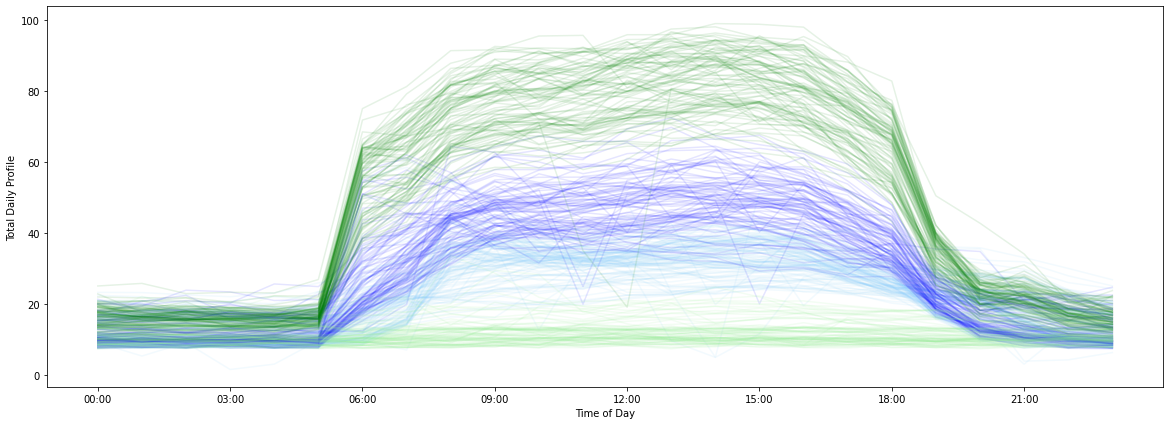

In [ ]:
clusterlist = list(dailyclusters.columns.get_level_values(0).unique())
matplotlib.rcParams['figure.figsize'] = 20, 7

styles2 = ['LightSkyBlue', 'b','LightGreen', 'g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
fig, ax = plt.subplots()
for col, style in zip(clusterlist, styles2):
    dailyclusters[col].plot(ax=ax, legend=False, style=style, alpha=0.1, xticks=np.arange(0, 86400, 10800))

ax.set_ylabel('Total Daily Profile')
ax.set_xlabel('Time of Day');

## Aggregate visualizations of the clusters

Now, let's aggregate and visualize the clusters as they exist across the time range:



In [ ]:
def timestampcombine(date,time):
    pydatetime = datetime.combine(date, time)
    return pydatetime

In [ ]:
def ClusterUnstacker(df):
    df = df.unstack().reset_index()
    df['timestampstring'] = pd.to_datetime(df.Date.astype("str") + " " + df.level_2.astype("str"))
    #pd.to_datetime(df.Date  df.level_2) #map(timestampcombine, )
    df = df.dropna()
    return df

In [ ]:
dailyclusters.unstack().reset_index().head()

,ClusterNo2,Date,level_2,0
0,1,2015-01-01,00:00:00,11.81
1,1,2015-01-01,01:00:00,11.29
2,1,2015-01-01,02:00:00,12.02
3,1,2015-01-01,03:00:00,11.45
4,1,2015-01-01,04:00:00,11.85


In [ ]:
dfclusterunstacked = ClusterUnstacker(dailyclusters)
dfclusterunstackedpivoted = pd.pivot_table(dfclusterunstacked, values=0, index='timestampstring', columns='ClusterNo2')

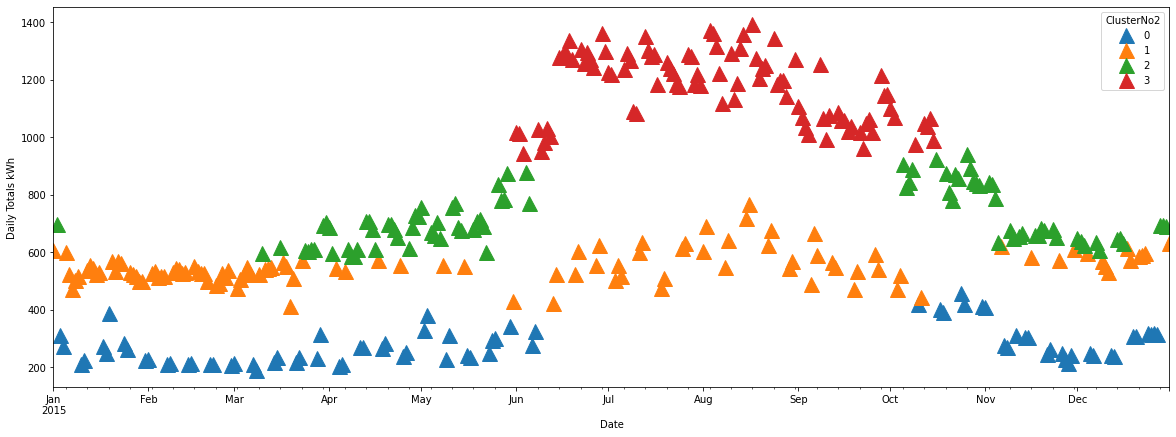

In [ ]:
clusteravgplot = dfclusterunstackedpivoted.resample('D').sum().replace(0, np.nan).plot(style="^",markersize=15)
clusteravgplot.set_ylabel('Daily Totals kWh')
clusteravgplot.set_xlabel('Date');

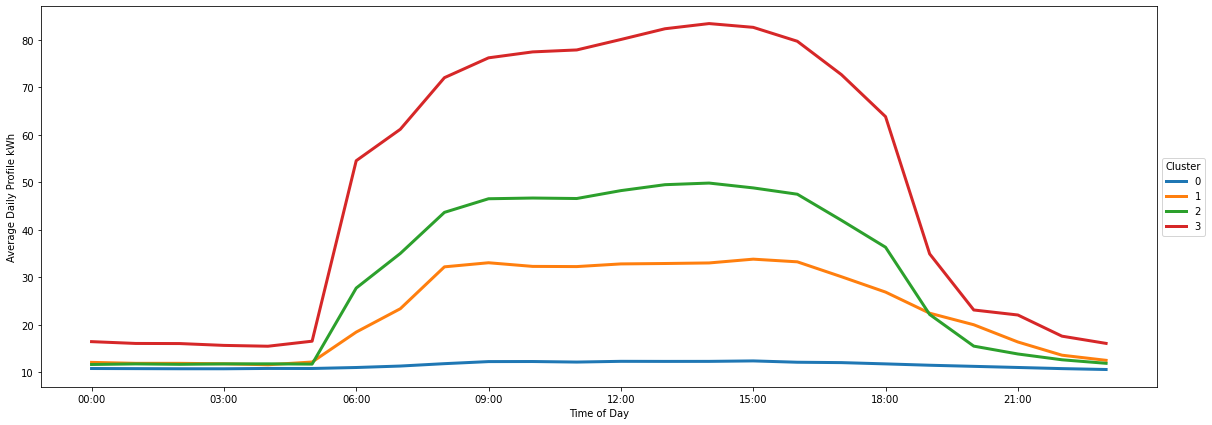

In [ ]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
dailyprofile = dfclusterunstackedpivoted.groupby('Time').mean().plot(figsize=(20,7),linewidth=3, xticks=np.arange(0, 86400, 10800))
dailyprofile.set_ylabel('Average Daily Profile kWh')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

In [ ]:
def DayvsClusterMaker(df):
    df.index = df.timestampstring
    df['Weekday'] = df.index.map(lambda t: t.date().weekday())
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    DayVsCluster = df.resample('D').mean().reset_index(drop=True)
    DayVsCluster = pd.pivot_table(DayVsCluster, values=0, index='ClusterNo2', columns='Weekday', aggfunc='count')
    DayVsCluster.columns = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    return DayVsCluster.T

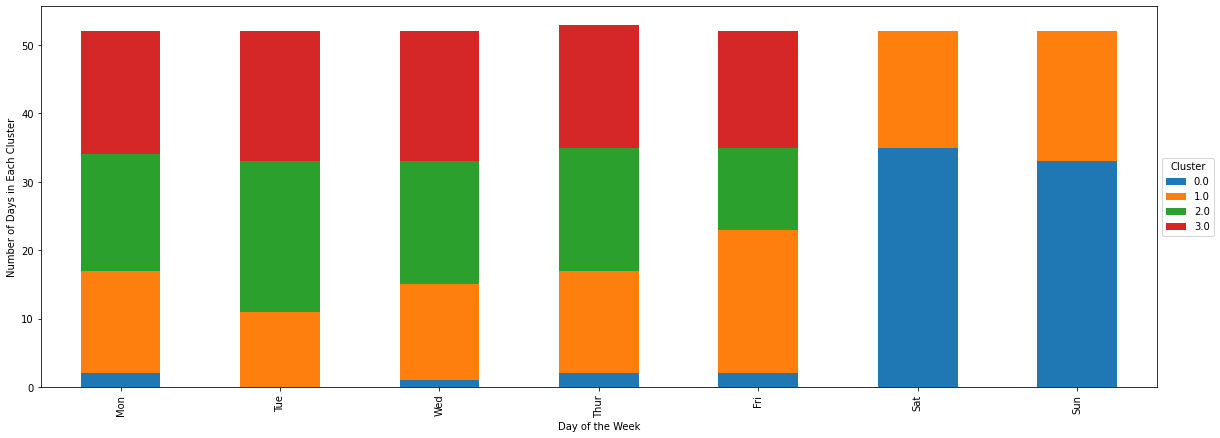

In [ ]:
DayVsCluster = DayvsClusterMaker(dfclusterunstacked)
DayVsClusterplot1 = DayVsCluster.plot(figsize=(20,7),kind='bar',stacked=True)
DayVsClusterplot1.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot1.set_xlabel('Day of the Week')
DayVsClusterplot1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

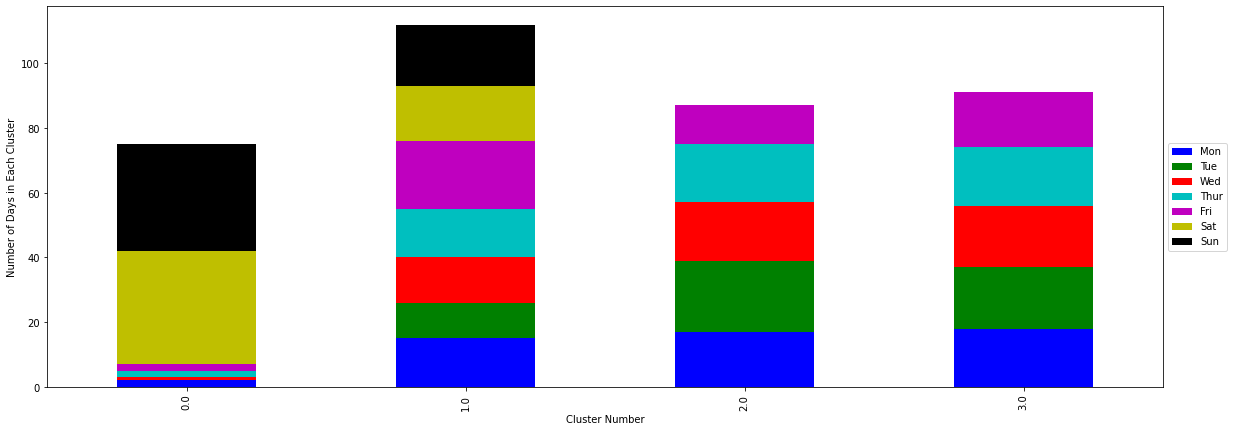

In [ ]:
DayVsClusterplot2 = DayVsCluster.T.plot(figsize=(20,7),kind='bar',stacked=True, color=['b','g','r','c','m','y','k']) #, color=colors2
DayVsClusterplot2.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot2.set_xlabel('Cluster Number')
DayVsClusterplot2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Electricity Prediction using Regression for Measurement and Verification

Prediction is a common machine learning (ML) technique used on building energy consumption data. This process is valuable for anomaly detection, load profile-based building control and measurement and verification procedures.

The graphic below comes from the IPMVP to show how prediction can be used for M&V to calculate how much energy **would have** been consumed if an energy savings intervention had not been implemented.



## Prediction for Measurement and Verification

![alt text](https://raw.githubusercontent.com/buds-lab/the-building-data-genome-project/master/docs/edx-graphics/EDX-ML-ScikitLearn-3.png)

There is an open publication that gives more information on how prediction in this realm can be approached: https://www.mdpi.com/2504-4990/1/3/56

There is an entire Kaggle Machine Learning competition also focused on this application: https://www.kaggle.com/c/ashrae-energy-prediction



## Load electricity data and weather data

First we can load the data from the BDG in the same as our previous weather analysis influence notebook from the Construction Phase videos

In [ ]:
df_prediction_data = pd.read_csv("UnivClass_Ciara.csv", parse_dates=True, index_col='timestamp')

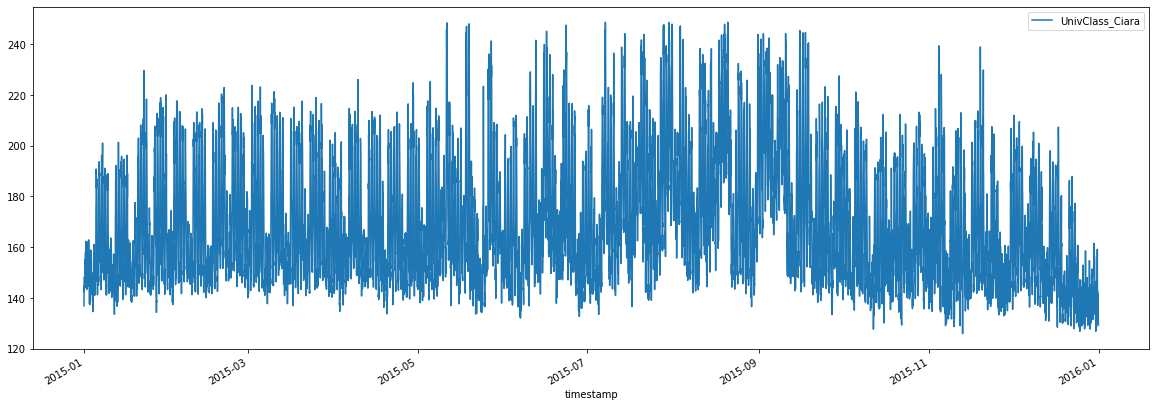

In [ ]:
df_prediction_data.plot(figsize=(20,7))

In [ ]:
os.chdir("/content/gdrive/My Drive/EDX Data Science for Construction, Architecture and Engineering/3 - Construction - Pandas Fundamentals/weather_data/")
weather_data = pd.read_csv("weather2.csv", index_col='timestamp', parse_dates=True)

In [ ]:
weather_hourly = weather_data.resample("H").mean()
weather_hourly_nooutlier = weather_hourly[weather_hourly > -40]
weather_hourly_nooutlier_nogaps = weather_hourly_nooutlier.fillna(method='ffill')

In [ ]:
temperature = weather_hourly_nooutlier_nogaps["TemperatureC"]

In [ ]:
weather_hourly_nooutlier_nogaps.head()

,Dew PointC,Humidity,Precipitationmm,Sea Level PressurehPa,TemperatureC,VisibilityKm,WindDirDegrees
timestamp,,,,,,,
2015-01-01 00:00:00,-15.0,54.0,NaN,1017.4,-7.2,16.1,230.0
2015-01-01 01:00:00,-14.4,55.0,NaN,1017.2,-6.6,16.1,240.0
2015-01-01 02:00:00,-14.4,55.0,NaN,1016.9,-6.6,16.1,220.0
2015-01-01 03:00:00,-14.4,55.0,NaN,1017.2,-6.6,16.1,220.0
2015-01-01 04:00:00,-14.4,55.0,NaN,1017.2,-6.6,16.1,210.0


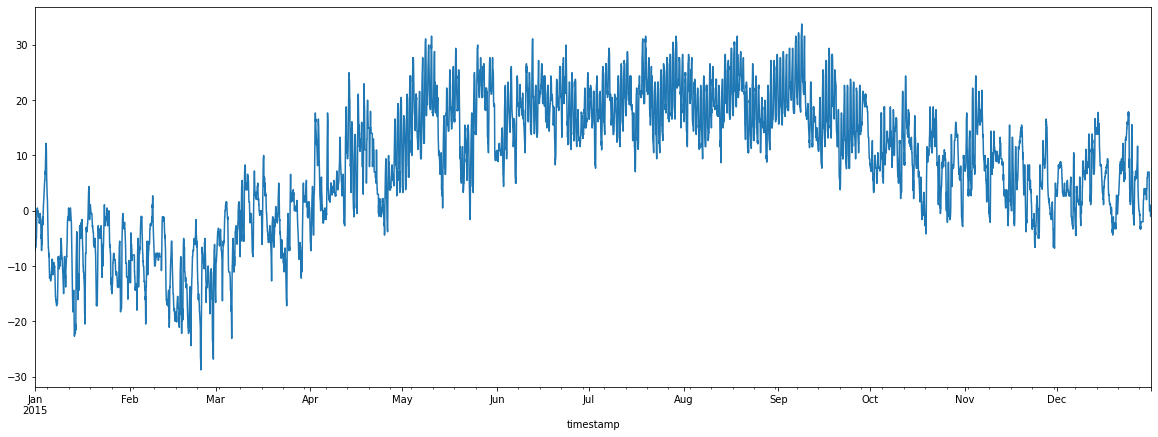

In [ ]:
temperature.plot(figsize=(20,7))

## Create Train and Test Datasets for Supervsed Learning

With **supervised learning**, the model is given a set of data that will be used to **train** the model to predict a specific objectice. In this case, we will use a few simple time series features as well as outdoor air temperature to predict how much energy a building uses.

For this demonstration, we will use three months of data from April, May, and June to prediction July.

In [ ]:
training_months = [4,5,6]
test_months = [7]

We can divide the data set by using the `datetime index` of the data frame and a function known as `.isin` to extract the months for the model

In [ ]:
trainingdata = df_prediction_data[df_prediction_data.index.month.isin(training_months)]
testdata = df_prediction_data[df_prediction_data.index.month.isin(test_months)]


In [ ]:
trainingdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2184 entries, 2015-04-01 00:00:00 to 2015-06-30 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UnivClass_Ciara  2184 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB


In [ ]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2015-07-01 00:00:00 to 2015-07-31 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UnivClass_Ciara  744 non-null    float64
dtypes: float64(1)
memory usage: 11.6 KB


We can extract the training input data features that will go into the model and the training **label** data which is what are are targeting to predict.

## Encoding Categorical Variables

We use the pandas `.get_dummies()` function to change the temporal variables of *time of day* and *day of week* into categories that the model can use more effectively. This process is known as [enconding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

In [ ]:
train_features = pd.concat([pd.get_dummies(trainingdata.index.hour),
                                     pd.get_dummies(trainingdata.index.dayofweek),
                                     pd.DataFrame(temperature[temperature.index.month.isin(training_months)].values)], axis=1).dropna()


In [ ]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,0,1,2,3,4,5,6,0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-5.5
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-6.1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-7.2
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-6.6
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-7.2


## Train a K-Neighbor Regressor Model

This model was chosen after following the process in the cheat sheet until a model that worked and provided good results was found.

In [ ]:
model = KNeighborsRegressor().fit(np.array(train_features), np.array(trainingdata.values));

In [ ]:
test_features = np.array(pd.concat([pd.get_dummies(testdata.index.hour),
                                    pd.get_dummies(testdata.index.dayofweek),
                                    pd.DataFrame(temperature[temperature.index.month.isin(test_months)].values)], axis=1).dropna())

In [ ]:
test_features

array([[ 1. ,  0. ,  0. , ...,  0. ,  0. , 17.7],
       [ 0. ,  1. ,  0. , ...,  0. ,  0. , 17.2],
       [ 0. ,  0. ,  1. , ...,  0. ,  0. , 16.6],
       ...,
       [ 0. ,  0. ,  0. , ...,  0. ,  0. , 17.7],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. , 18.3],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. , 17.7]])



## Use the Model to predict for the *Test* period

Then the model is given the `test_features` from the period which we want to predict. We can then merge those results and see how the model did

In [ ]:
predictions = model.predict(test_features)

In [ ]:
predicted_vs_actual = pd.concat([testdata, pd.DataFrame(predictions, index=testdata.index)], axis=1)

In [ ]:
predicted_vs_actual.columns = ["Actual", "Predicted"]

In [ ]:
predicted_vs_actual.head()

,Actual,Predicted
timestamp,,
2015-07-01 00:00:00,151.525002,171.324998
2015-07-01 01:00:00,152.575005,185.139999
2015-07-01 02:00:00,149.725006,170.325003
2015-07-01 03:00:00,151.125000,187.010001
2015-07-01 04:00:00,146.000000,171.700002


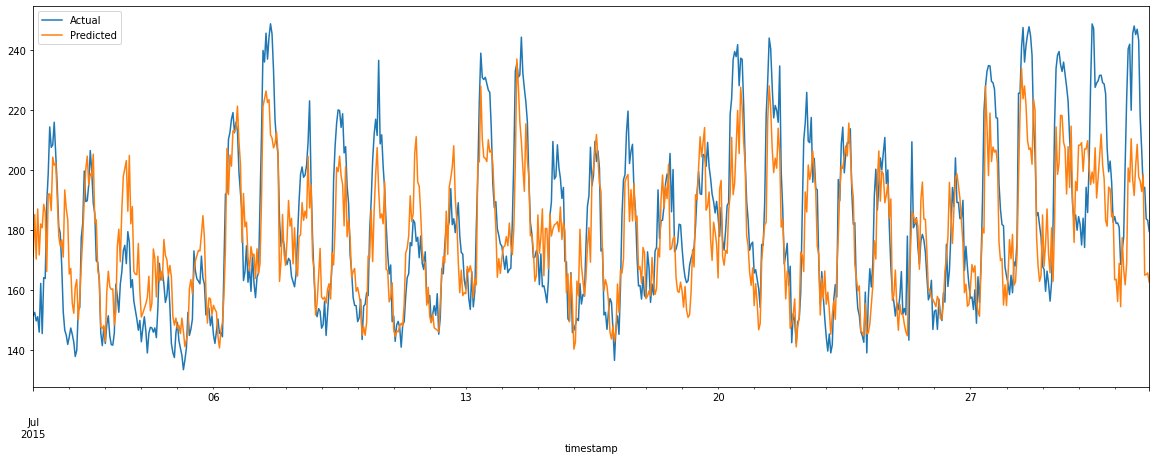

In [ ]:
predicted_vs_actual.plot()

In [ ]:
trainingdata.columns = ["Actual"]

In [ ]:
predicted_vs_actual_plus_training = pd.concat([trainingdata, predicted_vs_actual], sort=True)

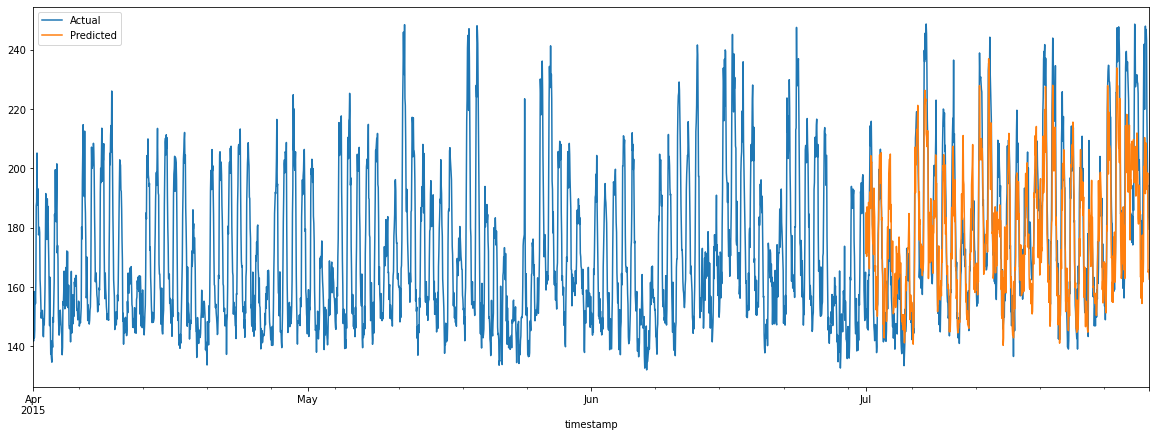

In [ ]:
predicted_vs_actual_plus_training.plot(figsize=(20,7))

## Regression evaluation metrics

In order to understand quanitatively how the model performed, we can use various evaluation metrics to understand how well the model compared to reality.

In this situation, let's use the error metric [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)

In [ ]:
# Calculate the absolute errors
errors = abs(predicted_vs_actual['Predicted'] - predicted_vs_actual['Actual'])
# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / predicted_vs_actual['Actual']))

In [ ]:
MAPE

6.8811507492394455